<a href="https://colab.research.google.com/github/rbarman/AnimeGANs/blob/master/Anime_face_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspiration from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [2]:
from IPython.display import Image as display_image
from google.colab import drive
import os
import random
import PIL
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
from tqdm.notebook import tqdm
%matplotlib inline

In [7]:
!git clone https://github.com/rbarman/AnimeGANs

Cloning into 'AnimeGANs'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 42 (delta 16), reused 11 (delta 3), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [8]:
%cd AnimeGANs/

/content/AnimeGANs


In [9]:
!ls

Anime_face_GAN.ipynb  device_utils.py  my_modules.py  README.md


In [10]:
from my_modules import Discriminator, Generator
from device_utils import get_default_device, DeviceDataLoader, to_device

**Get images**
- I saved results from https://github.com/bchao1/Anime-Face-Dataset to google drive
- Could get more samples using the haar cascade from https://github.com/nagadomi/animeface-2009

In [11]:
%%capture
drive.mount('/content/drive')
!tar -xvzf  /content/drive/My\ Drive/Anime-Faces.tgz

In [12]:
def view_rand_img(img_dir = '/content/AnimeGANs/cropped/'):
  imgs = os.listdir(img_dir)
  img_path = img_dir  + random.choice(imgs)
  print(img_path)
  return display_image(img_path)

/content/AnimeGANs/cropped/53516_2016.jpg


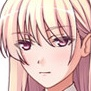

In [13]:
view_rand_img()

In [14]:
# There are some invalid images...
display_image('/content/AnimeGANs/cropped/44478_2013.jpg')

In [15]:
for img_name in os.listdir('/content/AnimeGANs/cropped/'):
  img_path = f'/content/AnimeGANs/cropped/{img_name}'
  try:
    _ = PIL.Image.open(img_path)
  except PIL.UnidentifiedImageError:
    #print(f'{img_path} is an invalid image')
    os.remove(img_path)

Create DataLoaders

In [12]:
ROOT_IMAGE_DIR = '/content/'
IMAGE_SIZE = 64
BATCH_SIZE = 128
LATENT_SIZE = 100
NUM_CHANNELS = 3
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
train_ds = ImageFolder(ROOT_IMAGE_DIR, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*STATS)]))

In [14]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3)

In [15]:
def show_batch(dl):
  images, _ = next(iter(dl))
  plt.figure(figsize=(8,8))
  plt.axis("off")
  # permuting because matplotlib needs (x,y, num channels) while tensor is (num channels, x, y)
  plt.imshow(make_grid(images.detach()[0:64],padding=2,normalize=True,).permute(1,2,0));

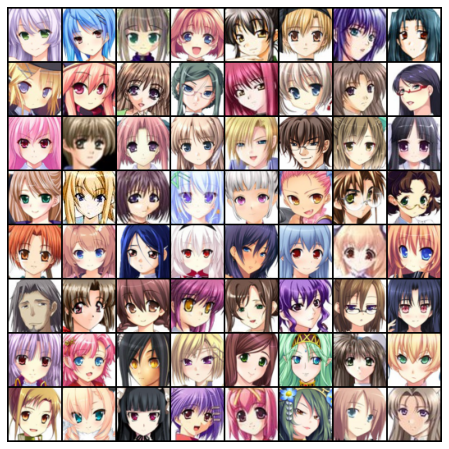

In [16]:
show_batch(train_dl)

In [17]:
device = get_default_device()
device

device(type='cuda')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)

In [19]:
images,labels = next(iter(train_dl))
images.shape, labels.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

Confirm shapes with Discriminator and Generator

In [20]:
# Discriminator classifies if an image is real or not
  # input is a batch of images
  # output is a batch of results
discriminator = Discriminator(num_features = 64)
discriminator = to_device(discriminator, device)
images,labels = next(iter(train_dl))

print(f'INPUT: ',images.shape)
out = discriminator(images)
print('OUTPUT: ',out.shape)

INPUT:  torch.Size([128, 3, 64, 64])
OUTPUT:  torch.Size([128, 1])


In [21]:
# Generator takes a vector of noise and creates images
  # input is batch of noise/random 
  # output is a batch of images
generator = Generator(latent_vector_len = LATENT_SIZE,num_features = 64)
generator = to_device(generator, device)
noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
print(f'INPUT: ',noise.shape)
out = generator(noise)
print('OUTPUT: ',out.shape)

INPUT:  torch.Size([128, 100, 1, 1])
OUTPUT:  torch.Size([128, 3, 64, 64])


Training Loop

In [ ]:
'''
pseudo code of training loop:

for epoch in epochs:
  for batch in train dataloader:
    
    # Train Discriminator
    - forward pass of {real} images to Discriminator
    - calculate loss + backwards pass

    - create batch of fake images from Generator
    - forward pass of images to Discriminator
    - calculate loss + backwards pass

    - add both gradients from both losses  + update Discriminator weights

    # Train Generator
    - foward pass of latent vector to create fake images
    - forward pass of fake images to Discriminator
    - calculate loss (how well the discrimator classifies the images are fake)
    - backwards pass + update weights
'''

'\npseudo code of training loop:\n\nfor epoch in epochs:\n  for batch in train dataloader:\n    \n    # Train Discriminator\n    - forward pass of {real} images to Discriminator\n    - calculate loss + backwards pass\n\n    - create batch of fake images from Generator\n    - forward pass of images to Discriminator\n    - calculate loss + backwards pass\n\n    - add both gradients from both losses  + update Discriminator weights\n\n    # Train Generator\n    - foward pass of latent vector to create fake images\n    - forward pass of fake images to Discriminator\n    - calculate loss (how well the discrimator classifies the images are fake)\n    - backwards pass + update weights\n'

In [ ]:
# images, _ = next(iter(train_dl))

# optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# train_discriminator(images)

In [ ]:
# optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# train_generator()

7.022176191640028e-07

In [61]:
class GANTrainer():
  def __init__(self, train_dl
               , num_generator_features = 64
               , num_discriminator_feataures = 64
               ,latent_size = 100
               , lr=.0002
               ,gen_dir = '/content/AnimeGANS/generated/'
               ):
    
    self.device = get_default_device()
    self.train_dl = train_dl
    self.batch_size = train_dl.dl.batch_size
    self.latent_size = latent_size
    self.num_generator_features = num_generator_features
    self.num_discriminator_feataures = num_discriminator_feataures
    self.gen_dir = gen_dir

    # set up Generator and Discriminators and put on device
    self.discriminator = Discriminator(num_features = self.num_generator_features)
    self.generator = Generator(latent_vector_len = self.latent_size,num_features = self.num_discriminator_feataures)
    self.discriminator = to_device(self.discriminator, self.device)
    self.generator = to_device(self.generator, self.device)

    # set up optimizers
    self.optimizerD = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    self.optimizerG = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))

  def train_generator(self):
    self.generator.zero_grad()

    # create fake images from the generator
    noise = torch.randn(self.batch_size, self.latent_size, 1, 1, device=self.device)
    fake_images = self.generator(noise)

    # pass fake images through discriminator
    predictions_fake = self.discriminator(fake_images)
    labels = torch.ones(self.batch_size,1,device=self.device)
    loss_fake = F.binary_cross_entropy(predictions_fake, labels)

    # backwards pass + update generator weights
    loss_fake.backward()
    self.optimizerG.step()

    return loss_fake.item()

  def save_generated_samples(self,iter, gen_dir):
    ''' Save generated images from Generator to disk
        - iter = training iteration number
        - This could be replaced with tensor board?
    '''

    os.makedirs(gen_dir, exist_ok=True)

    noise = torch.randn(self.batch_size, self.latent_size, 1, 1, device=self.device)
    fake_images = self.generator(noise)
    fake_name = f'{iter}.png'

    save_image(make_grid(fake_images[:64], padding=2, normalize=True,nrow=8),
              f'{gen_dir}{fake_name}')
    
    print(f'Saving to {gen_dir}{fake_name}')

  def train_discriminator(self,images):

    # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
    self.discriminator.zero_grad()

    # pass through real images
    predictions_real = self.discriminator(images)
    labels = torch.ones(images.shape[0],1,device=self.device)
    loss_real = F.binary_cross_entropy(predictions_real, labels)

    # create fake images from the generator
    noise = torch.randn(images.shape[0], self.latent_size, 1, 1, device=self.device)
    fake_images = self.generator(noise)
    
    # pass through fake images
    predictions_fake = self.discriminator(fake_images)
    labels = torch.zeros(images.shape[0],1,device=self.device)
    loss_fake = F.binary_cross_entropy(predictions_fake, labels)

    # backwards pass and update discriminator weights
      # total_loss = loss_fake + loss_real
      # total_loss.backward() should be the same thing (?)
    loss_fake.backward()
    loss_real.backward()
    total_loss = loss_fake + loss_real
    
    self.optimizerD.step()

    # return total loss, 'score' of real predictions, and 'score' of fake predictions
    return total_loss.item(), torch.mean(predictions_real).mean(), torch.mean(predictions_fake).mean()

  def train(self,num_epochs, iter_start=1):

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(num_epochs):
      for images, _ in tqdm(self.train_dl):

        # Train discriminator
        loss_d, real_score, fake_score = self.train_discriminator(images)
        # Train generator
        loss_g = self.train_generator()

      # Record losses & scores
      losses_g.append(loss_g)
      losses_d.append(loss_d)
      real_scores.append(real_score)
      fake_scores.append(fake_score)
      
      self.save_generated_samples(epoch+iter_start, self.gen_dir)

      # Log losses & scores (last batch)
      print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, num_epochs, loss_g, loss_d, real_score, fake_score))
      
    return losses_g, losses_d, real_scores, fake_scores

In [62]:
gan = GANTrainer(train_dl)
history = gan.train(1)


Saving to /content/AnimeGANS/generated/1.png
Epoch [1/1], loss_g: 2.9943, loss_d: 0.6775, real_score: 0.6549, fake_score: 0.1677


Results per epoch

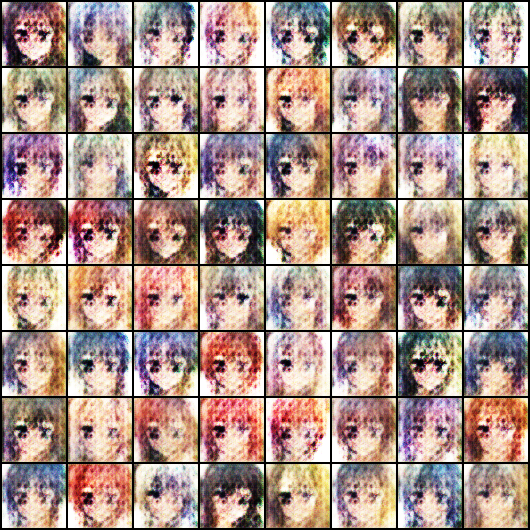

In [63]:
display_image('/content/AnimeGANS/generated/1.png')

Still needs more epochs... Generated images are still blurry